In [2]:
!pip install torch_geometric_temporal

/Users/alexcismaru/.zshenv:1: bad assignment


In [2]:
import numpy as np
import torch
from torch_geometric_temporal.dataset import PemsBayDatasetLoader
from torch_geometric_temporal.signal import StaticGraphTemporalSignal
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load PEMS-BAY dataset
loader = PemsBayDatasetLoader()
dataset = loader.get_dataset()

# Extract necessary data
edge_index = dataset.edge_index
edge_weight = dataset.edge_weight
node_features = dataset.features
node_targets = dataset.targets

# Define a custom StaticGraphTemporalSignal class to include edge attributes
class CustomStaticGraphTemporalSignal(StaticGraphTemporalSignal):
    def __init__(self, edge_index, edge_weight, features, targets):
        super(CustomStaticGraphTemporalSignal, self).__init__(edge_index, edge_weight, features, targets)
        self.edge_weight = edge_weight

    def __getitem__(self, idx):
        data = super(CustomStaticGraphTemporalSignal, self).__getitem__(idx)
        data.edge_attr = torch.tensor(self.edge_weight, dtype=torch.float)
        return data

# Initialize the dataset with edge attributes
train_dataset = CustomStaticGraphTemporalSignal(
    edge_index=edge_index, 
    edge_weight=edge_weight, 
    features=node_features, 
    targets=node_targets
)

In [3]:
# Convert features and targets to PyTorch tensors
train_features = [snapshot.x.clone().detach().float() for snapshot in train_dataset]
train_targets = [snapshot.y.clone().detach().float() for snapshot in train_dataset]

# Define the sequence length (N) to keep only the first N time steps
N = 1

# Truncate each sequence in train and test sets to the first N time steps
train_features = [x[:, :, :N] for x in train_features]
train_targets = [y[:, :, :N] for y in train_targets]

# Train-test split
train_features_split, test_features_split, train_targets_split, test_targets_split = train_test_split(
    train_features, train_targets, test_size=0.2, random_state=42
)

print(f"Training samples: {len(train_features_split)}")
print(f"Test samples: {len(test_features_split)}")

# Combine features and targets for joint scaling
train_data_combined = np.concatenate([x.reshape(-1, x.shape[-1]) for x in train_features_split] +
                                     [y.reshape(-1, y.shape[-1]) for y in train_targets_split], axis=0)

scaler = StandardScaler()
scaler.fit(train_data_combined)

Training samples: 41665
Test samples: 10417


StandardScaler()

In [4]:
# Remove constant second dimension from features if it's not providing useful information
train_features = [x[:, :1, :] for x in train_features]  # Keeps only the first feature
train_targets = [y[:, :1, :] for y in train_targets]  # Assuming the same for targets

# Apply the same slicing to the train-test split
train_features_split, test_features_split, train_targets_split, test_targets_split = train_test_split(
    train_features, train_targets, test_size=0.2, random_state=42
)


In [5]:
# Now transform the features and targets separately using the same scaler
train_features_split_scaled = [scaler.transform(x.reshape(-1, x.shape[-1])).reshape(x.shape) for x in train_features_split]
train_targets_split_scaled = [scaler.transform(y.reshape(-1, y.shape[-1])).reshape(y.shape) for y in train_targets_split]

# Apply to test set too
test_features_split_scaled = [scaler.transform(x.reshape(-1, x.shape[-1])).reshape(x.shape) for x in test_features_split]
test_targets_split_scaled = [scaler.transform(y.reshape(-1, y.shape[-1])).reshape(y.shape) for y in test_targets_split]

# Convert normalized features/targets back to tensors
train_features_split_scaled = [torch.tensor(x) for x in train_features_split_scaled]
train_targets_split_scaled = [torch.tensor(y) for y in train_targets_split_scaled]
test_features_split_scaled = [torch.tensor(x) for x in test_features_split_scaled]
test_targets_split_scaled = [torch.tensor(y) for y in test_targets_split_scaled]

In [6]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

# Model Definition
class SGCN_LSTM_Model(nn.Module):
    def __init__(self, node_features, hidden_dim, lstm_hidden_dim, num_nodes):
        super(SGCN_LSTM_Model, self).__init__()
        self.gcn1 = GCNConv(in_channels=1, out_channels=hidden_dim, add_self_loops=False)  # Set in_channels=1
        self.gcn2 = GCNConv(in_channels=hidden_dim, out_channels=hidden_dim, add_self_loops=False)
        self.lstm = nn.LSTM(hidden_dim, lstm_hidden_dim, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_dim, 1)
        self.num_nodes = num_nodes

    def forward(self, x, edge_index, edge_weight=None):
        # x: Shape [num_nodes, num_features, seq_length]
        num_nodes, num_features, seq_length = x.shape

        gcn_outputs = []

        # Process each time step
        for t in range(seq_length):
            x_t = x[:, :, t]  # Shape: [num_nodes, num_features]
            x_t = F.relu(self.gcn1(x_t, edge_index, edge_weight))
            x_t = F.relu(self.gcn2(x_t, edge_index, edge_weight))
            gcn_outputs.append(x_t)

        # Stack GCN outputs to form LSTM input
        x = torch.stack(gcn_outputs, dim=1)  # Shape: [num_nodes, seq_length, hidden_dim]

        # LSTM layer
        lstm_out, _ = self.lstm(x)  # Shape: [num_nodes, seq_length, lstm_hidden_dim]
        lstm_out = lstm_out[:, -1, :]  # Take the output from the last time step

        # Fully connected layer
        out = self.fc(lstm_out)  # Shape: [num_nodes, 1]

        return out.squeeze()


In [7]:
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.7):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.mae = nn.L1Loss()
        self.mse = nn.MSELoss()

    def forward(self, output, target):
        return self.alpha * self.mae(output, target) + (1 - self.alpha) * self.mse(output, target)

criterion = CombinedLoss(alpha=0.7)

In [8]:
from torch.optim.lr_scheduler import StepLR

# Instantiate the model
node_features = 2  # Example value, adjust according to your data
hidden_dim = 64  # Example value
lstm_hidden_dim = 32  # Example value
num_nodes = train_features_split_scaled[0].shape[0]  # Example value

print("Initializing the model...")
model = SGCN_LSTM_Model(node_features, hidden_dim, lstm_hidden_dim, num_nodes)

# Loss function and optimizer
criterion = CombinedLoss(alpha=0.7)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #Original value was 0.001

scheduler = StepLR(optimizer, step_size=10, gamma=0.5)  # Reduces learning rate by half every 10 epochs

Initializing the model...


In [9]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased. Saving model...')
        torch.save(model.state_dict(), 'checkpoint.pt')


# Initialize early stopping
early_stopping = EarlyStopping(patience=5, verbose=True)

# Training Loop with Early Stopping
epochs = 100
batch_size = 128
train_losses = []
val_losses = []
clip_value = 1.0  # Gradient clipping value

model.train()
for epoch in range(epochs):
    total_train_loss = 0.0
    print(f"Starting Epoch {epoch+1}/{epochs}")

    # Training Loop
    for t in range(0, len(train_features_split_scaled), batch_size):
        batch_features = train_features_split_scaled[t:t+batch_size]
        batch_targets = train_targets_split_scaled[t:t+batch_size]

        optimizer.zero_grad()  # Clear previous gradients
        batch_loss = 0.0

        # Process batch data
        for x, y in zip(batch_features, batch_targets):
            x, y = x.clone().detach().float(), y.clone().detach().float()
            edge_index = torch.tensor(train_dataset.edge_index, dtype=torch.long)
            edge_weight = torch.tensor(train_dataset.edge_weight, dtype=torch.float) if train_dataset.edge_weight is not None else None

            # Forward pass
            output = model(x, edge_index, edge_weight)
            target = y[:, 0, -1]

            # Compute loss
            loss = criterion(output, target)
            loss.backward()  # Backpropagation
            
            # Gradient Clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

            optimizer.step()  # Update model weights
            batch_loss += loss.item()

        total_train_loss += batch_loss / batch_size

        # Log training loss for every 10 batches
        #if t % (batch_size * 10) == 0:
           # print(f"    Batch {t // batch_size + 1} Avg Loss: {batch_loss / batch_size:.4f}")

    avg_train_loss = total_train_loss / len(train_features_split_scaled)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1}/{epochs} completed. Average Training Loss: {avg_train_loss:.4f}")

    # Validation Loop
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0.0
    with torch.no_grad():
        for t in range(0, len(test_features_split_scaled), batch_size):
            batch_features = test_features_split_scaled[t:t+batch_size]
            batch_targets = test_targets_split_scaled[t:t+batch_size]

            for x, y in zip(batch_features, batch_targets):
                x, y = x.clone().detach().float(), y.clone().detach().float()
                output = model(x, edge_index, edge_weight)
                target = y[:, 0, -1]
                val_loss = criterion(output, target)
                total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(test_features_split_scaled)
    val_losses.append(avg_val_loss)
    print(f"Validation Loss after Epoch {epoch+1}: {avg_val_loss:.4f}")

    # Check early stopping
    early_stopping(avg_val_loss, model)

    # If early stopping triggered, halt training
    if early_stopping.early_stop:
        print("Early stopping triggered. Stopping training.")
        break
    
    # Step the scheduler
    scheduler.step()

    model.train()  # Set the model back to training mode for the next epoch

# Plotting training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


Starting Epoch 1/100


KeyboardInterrupt: 

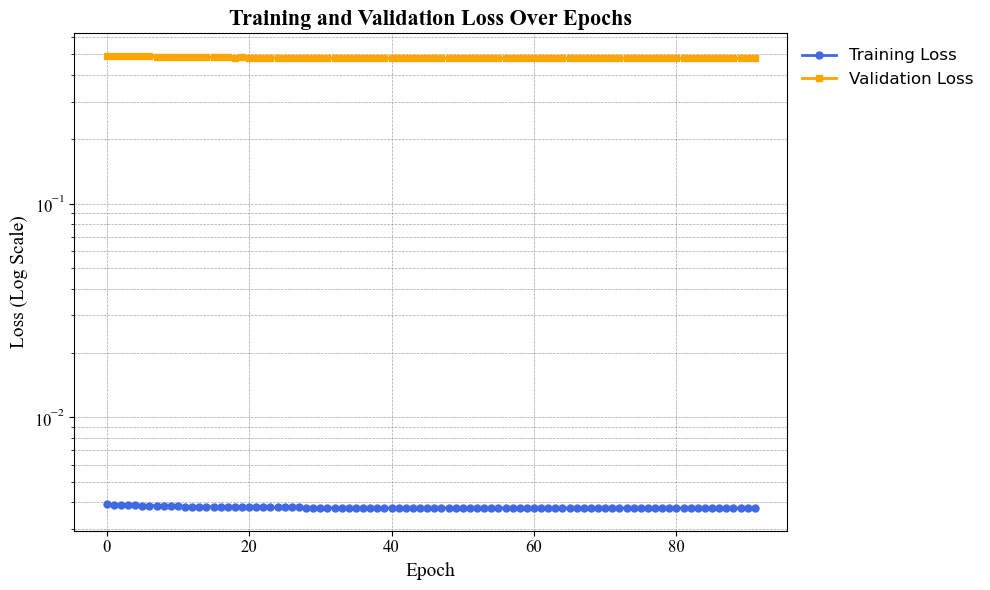

In [100]:
import matplotlib.pyplot as plt

# Plotting training and validation losses with log scale
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='royalblue', linewidth=2, marker='o', markersize=5)
plt.plot(val_losses, label='Validation Loss', color='orange', linewidth=2, marker='s', markersize=5)

# Set plot labels and title with larger font sizes and professional font
plt.xlabel('Epoch', fontsize=14, fontname='Times New Roman')
plt.ylabel('Loss (Log Scale)', fontsize=14, fontname='Times New Roman')
plt.title('Training and Validation Loss Over Epochs', fontsize=16, fontname='Times New Roman', weight='bold')

# Set y-axis to log scale
plt.yscale('log')

# Customize grid for a more professional look
plt.grid(True, which="both", linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

# Customize legend to be outside the plot area if needed
plt.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

# Set tick parameters for better readability
plt.xticks(fontsize=12, fontname='Times New Roman')
plt.yticks(fontsize=12, fontname='Times New Roman')

# Tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


In [87]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Assuming your evaluation code is as you've shared it

# Evaluation with dtype fixes and reduced test samples (processed in batches)
model.eval()
total_test_loss = 0.0
all_predictions = []
all_actuals = []

# Subset the test set for faster evaluation (first 2000 samples, adjust as needed)
test_features_subset = test_features_split_scaled
test_targets_subset = test_targets_split_scaled


print(f"Starting evaluation on {len(test_features_subset)} test samples in batches.")

for t in range(0, len(test_features_subset), batch_size):
    batch_features = test_features_subset[t:t+batch_size]
    batch_targets = test_targets_subset[t:t+batch_size]
    
    for i, (x, y) in enumerate(zip(batch_features, batch_targets)):
        # Ensure that x and y are of type float32
        x = torch.tensor(x).float()  # Convert x to float32
        y = torch.tensor(y).float()  # Convert y to float32

        #print(f"x shape: {x.shape}, y shape: {y.shape}")

        # Ensure edge_index is a LongTensor (int64) and has correct shape
        edge_index = torch.tensor(train_dataset.edge_index, dtype=torch.long)
        # Ensure edge_weight is a FloatTensor (float32) or None
        edge_weight = torch.tensor(train_dataset.edge_weight, dtype=torch.float) if train_dataset.edge_weight is not None else None

        # Forward pass
       # print(f"Performing forward pass for batch {t//batch_size + 1}, sample {i+1}...")
        output = model(x, edge_index, edge_weight)  # Shape: [num_nodes]
        target = y[:, 0, -1]  # Target for the last time step of the first feature
       # print(f"output shape: {output.shape}, target shape: {target.shape}")

        all_predictions.append(output.detach().cpu().numpy().flatten())  # Flatten output for concatenation
        all_actuals.append(target.detach().cpu().numpy().flatten())      # Flatten target for concatenation

        # Compute loss
        loss = criterion(output, target)
        #print(f"Loss for batch {t//batch_size + 1}, sample {i+1}: {loss.item()}")
        total_test_loss += loss.item()

# Calculate and print average test loss
avg_test_loss = total_test_loss / len(test_features_subset)
print(f"\nTest Loss: {avg_test_loss:.4f}")

# Convert predictions and actuals to numpy arrays for easier manipulation
all_predictions = np.concatenate(all_predictions, axis=0).reshape(-1, 1)
all_actuals = np.concatenate(all_actuals, axis=0).reshape(-1, 1)

# Save predictions and actual values to files
np.save("all_predictions.npy", all_predictions)
np.save("all_actuals.npy", all_actuals)

print("Predictions and actual values saved as 'all_predictions.npy' and 'all_actuals.npy'.")


Starting evaluation on 10417 test samples in batches.
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 1, sample 1...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 1, sample 1: 0.4910898208618164
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 1, sample 2...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 1, sample 2: 0.15129056572914124
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 1, sample 3...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 1, sample 3: 0.39707571268081665
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 1, sample 4...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 1, sample 4: 0.4037145972251892
x shape: torch.Size([325, 1, 1])

/var/folders/0r/42s0y7w165x_jyn8v8934q0h0000gn/T/ipykernel_72530/117571737.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).float()  # Convert x to float32
/var/folders/0r/42s0y7w165x_jyn8v8934q0h0000gn/T/ipykernel_72530/117571737.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).float()  # Convert y to float32


output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 1, sample 79: 0.7729835510253906
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 1, sample 80...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 1, sample 80: 0.6102657914161682
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 1, sample 81...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 1, sample 81: 0.16568878293037415
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 1, sample 82...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 1, sample 82: 0.9230836629867554
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 1, sample 83...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 2, sample 48: 0.8483452796936035
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 2, sample 49...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 2, sample 49: 0.9617685079574585
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 2, sample 50...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 2, sample 50: 0.20378144085407257
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 2, sample 51...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 2, sample 51: 0.24540168046951294
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 2, sample 52...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batc

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 3, sample 29: 0.3147660493850708
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 3, sample 30...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 3, sample 30: 0.2234775274991989
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 3, sample 31...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 3, sample 31: 0.5308073163032532
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 3, sample 32...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 3, sample 32: 0.2025517076253891
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 3, sample 33...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 3, sample 117: 1.0836246013641357
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 3, sample 118...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 3, sample 118: 0.34302178025245667
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 3, sample 119...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 3, sample 119: 0.1421896517276764
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 3, sample 120...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 3, sample 120: 0.8247255086898804
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 3, sample 121...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss f

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 4, sample 76: 0.3094117343425751
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 4, sample 77...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 4, sample 77: 0.14241644740104675
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 4, sample 78...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 4, sample 78: 0.146235853433609
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 4, sample 79...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 4, sample 79: 1.6095166206359863
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 4, sample 80...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 5, sample 38: 0.21033024787902832
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 5, sample 39...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 5, sample 39: 0.5754237174987793
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 5, sample 40...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 5, sample 40: 0.17369917035102844
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 5, sample 41...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 5, sample 41: 0.13607896864414215
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 5, sample 42...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for bat

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 5, sample 128: 1.2393455505371094
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 6, sample 1...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 6, sample 1: 0.20869803428649902
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 6, sample 2...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 6, sample 2: 0.14525055885314941
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 6, sample 3...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 6, sample 3: 1.3542689085006714
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 6, sample 4...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 6, s

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 6, sample 80: 0.18252652883529663
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 6, sample 81...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 6, sample 81: 0.15278260409832
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 6, sample 82...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 6, sample 82: 0.263679563999176
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 6, sample 83...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 6, sample 83: 1.4918651580810547
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 6, sample 84...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 6,

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 7, sample 32: 0.17632974684238434
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 7, sample 33...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 7, sample 33: 0.7185744047164917
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 7, sample 34...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 7, sample 34: 0.16334125399589539
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 7, sample 35...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 7, sample 35: 0.23909318447113037
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 7, sample 36...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for bat

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 7, sample 126: 0.15280696749687195
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 7, sample 127...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 7, sample 127: 0.15631145238876343
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 7, sample 128...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 7, sample 128: 0.27351394295692444
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 8, sample 1...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 8, sample 1: 0.2525925040245056
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 8, sample 2...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for b

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 8, sample 87: 0.9263495206832886
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 8, sample 88...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 8, sample 88: 0.15050162374973297
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 8, sample 89...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 8, sample 89: 0.16520707309246063
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 8, sample 90...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 8, sample 90: 0.989883303642273
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 8, sample 91...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 9, sample 48: 0.1586855947971344
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 9, sample 49...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 9, sample 49: 0.1493925154209137
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 9, sample 50...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 9, sample 50: 0.1984122395515442
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 9, sample 51...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 9, sample 51: 0.20664499700069427
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 9, sample 52...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 10, sample 11: 0.23984867334365845
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 10, sample 12...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 10, sample 12: 0.2188151329755783
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 10, sample 13...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 10, sample 13: 0.17967014014720917
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 10, sample 14...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 10, sample 14: 0.24816592037677765
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 10, sample 15...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 10, sample 102: 1.3888394832611084
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 10, sample 103...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 10, sample 103: 0.33346712589263916
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 10, sample 104...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 10, sample 104: 0.1616223007440567
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 10, sample 105...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 10, sample 105: 1.060126781463623
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 10, sample 106...
output shape: torch.Size([325]), target shape: torch.Size([325])

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 11, sample 64: 1.7726290225982666
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 11, sample 65...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 11, sample 65: 0.23838116228580475
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 11, sample 66...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 11, sample 66: 0.2520751655101776
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 11, sample 67...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 11, sample 67: 0.16994309425354004
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 11, sample 68...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss 

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 12, sample 22: 0.48831796646118164
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 12, sample 23...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 12, sample 23: 0.226811945438385
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 12, sample 24...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 12, sample 24: 0.9575600624084473
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 12, sample 25...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 12, sample 25: 0.20731596648693085
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 12, sample 26...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss f

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 12, sample 61: 0.9464893341064453
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 12, sample 62...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 12, sample 62: 0.19082598388195038
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 12, sample 63...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 12, sample 63: 0.4293530583381653
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 12, sample 64...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 12, sample 64: 0.4690971374511719
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 12, sample 65...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss f

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 13, sample 40: 0.1937316507101059
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 13, sample 41...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 13, sample 41: 0.9404321312904358
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 13, sample 42...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 13, sample 42: 1.2376375198364258
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 13, sample 43...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 13, sample 43: 0.16826212406158447
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 13, sample 44...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss f

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 14, sample 1: 0.1485718935728073
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 14, sample 2...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 14, sample 2: 0.14591503143310547
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 14, sample 3...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 14, sample 3: 0.2516233026981354
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 14, sample 4...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 14, sample 4: 0.42822471261024475
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 14, sample 5...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batc

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 14, sample 90: 1.1740496158599854
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 14, sample 91...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 14, sample 91: 0.1667357236146927
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 14, sample 92...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 14, sample 92: 0.2464110255241394
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 14, sample 93...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 14, sample 93: 0.196855366230011
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 14, sample 94...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 15, sample 44: 0.19948913156986237
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 15, sample 45...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 15, sample 45: 0.1683492809534073
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 15, sample 46...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 15, sample 46: 0.23872658610343933
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 15, sample 47...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 15, sample 47: 0.5455904006958008
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 15, sample 48...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss 

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 16, sample 4: 0.17980916798114777
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 16, sample 5...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 16, sample 5: 0.2024906873703003
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 16, sample 6...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 16, sample 6: 1.0318434238433838
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 16, sample 7...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 16, sample 7: 0.17491495609283447
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 16, sample 8...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batc

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 16, sample 101: 1.2544771432876587
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 16, sample 102...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 16, sample 102: 1.6850048303604126
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 16, sample 103...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 16, sample 103: 1.0014232397079468
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 16, sample 104...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 16, sample 104: 0.15168547630310059
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 16, sample 105...
output shape: torch.Size([325]), target shape: torch.Size([325]

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 17, sample 68: 1.163801670074463
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 17, sample 69...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 17, sample 69: 0.14207033812999725
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 17, sample 70...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 17, sample 70: 0.8526244759559631
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 17, sample 71...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 17, sample 71: 0.14643310010433197
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 17, sample 72...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss f

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 18, sample 27: 1.3157994747161865
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 18, sample 28...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 18, sample 28: 0.6561903357505798
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 18, sample 29...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 18, sample 29: 0.3997700810432434
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 18, sample 30...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 18, sample 30: 1.2058314085006714
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 18, sample 31...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss fo

Loss for batch 18, sample 123: 0.14628824591636658
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 18, sample 124...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 18, sample 124: 1.9364099502563477
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 18, sample 125...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 18, sample 125: 0.16283835470676422
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 18, sample 126...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 18, sample 126: 0.17712579667568207
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 18, sample 127...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 18, sample 127: 0.19724424183368683
x shape: t

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 19, sample 92: 0.4742656350135803
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 19, sample 93...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 19, sample 93: 0.6846067905426025
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 19, sample 94...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 19, sample 94: 1.7221238613128662
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 19, sample 95...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 19, sample 95: 0.990760326385498
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 19, sample 96...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 20, sample 59: 0.28243815898895264
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 20, sample 60...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 20, sample 60: 0.13997751474380493
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 20, sample 61...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 20, sample 61: 1.2032475471496582
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 20, sample 62...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 20, sample 62: 0.1640329211950302
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 20, sample 63...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss 

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 21, sample 23: 0.1492047905921936
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 21, sample 24...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 21, sample 24: 1.5538630485534668
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 21, sample 25...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 21, sample 25: 1.5878373384475708
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 21, sample 26...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 21, sample 26: 0.15033714473247528
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 21, sample 27...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss f

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 21, sample 96: 0.28535211086273193
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 21, sample 97...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 21, sample 97: 0.24675291776657104
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 21, sample 98...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 21, sample 98: 0.266405314207077
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 21, sample 99...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 21, sample 99: 0.14578771591186523
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 21, sample 100...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 22, sample 19: 0.14881454408168793
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 22, sample 20...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 22, sample 20: 1.1949366331100464
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 22, sample 21...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 22, sample 21: 1.0850203037261963
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 22, sample 22...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 22, sample 22: 0.1738223433494568
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 22, sample 23...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss f

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 22, sample 100: 1.6659579277038574
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 22, sample 101...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 22, sample 101: 0.42669206857681274
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 22, sample 102...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 22, sample 102: 1.0526798963546753
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 22, sample 103...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 22, sample 103: 0.2218666970729828
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 22, sample 104...
output shape: torch.Size([325]), target shape: torch.Size([325]

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 23, sample 60: 0.2696462869644165
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 23, sample 61...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 23, sample 61: 0.8951334953308105
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 23, sample 62...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 23, sample 62: 0.15298449993133545
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 23, sample 63...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 23, sample 63: 0.3002977967262268
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 23, sample 64...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss f

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 24, sample 24: 0.14181679487228394
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 24, sample 25...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 24, sample 25: 0.8081743717193604
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 24, sample 26...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 24, sample 26: 0.9473211765289307
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 24, sample 27...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 24, sample 27: 0.28474724292755127
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 24, sample 28...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss 

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 24, sample 104: 0.17772497236728668
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 24, sample 105...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 24, sample 105: 0.3196604251861572
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 24, sample 106...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 24, sample 106: 0.24421526491641998
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 24, sample 107...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 24, sample 107: 0.28033095598220825
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 24, sample 108...
output shape: torch.Size([325]), target shape: torch.Size([32

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 25, sample 70: 0.2756182849407196
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 25, sample 71...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 25, sample 71: 0.17675602436065674
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 25, sample 72...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 25, sample 72: 0.2200588881969452
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 25, sample 73...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 25, sample 73: 0.15648408234119415
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 25, sample 74...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss 

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 26, sample 26: 0.175373375415802
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 26, sample 27...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 26, sample 27: 1.2873866558074951
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 26, sample 28...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 26, sample 28: 0.21013955771923065
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 26, sample 29...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 26, sample 29: 0.15346276760101318
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 26, sample 30...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss f

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 26, sample 118: 0.23834429681301117
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 26, sample 119...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 26, sample 119: 0.14086954295635223
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 26, sample 120...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 26, sample 120: 0.20140637457370758
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 26, sample 121...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 26, sample 121: 0.6393041610717773
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 26, sample 122...
output shape: torch.Size([325]), target shape: torch.Size([32

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 27, sample 78: 0.3071838617324829
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 27, sample 79...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 27, sample 79: 0.8306008577346802
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 27, sample 80...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 27, sample 80: 0.1691981852054596
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 27, sample 81...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 27, sample 81: 0.17307797074317932
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 27, sample 82...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss f

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 28, sample 24: 0.18681906163692474
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 28, sample 25...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 28, sample 25: 1.0283143520355225
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 28, sample 26...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 28, sample 26: 1.3454270362854004
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 28, sample 27...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 28, sample 27: 0.2295875996351242
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 28, sample 28...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss f

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 28, sample 92: 0.14688953757286072
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 28, sample 93...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 28, sample 93: 0.14103111624717712
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 28, sample 94...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 28, sample 94: 1.0717169046401978
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 28, sample 95...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 28, sample 95: 0.20191875100135803
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 28, sample 96...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 29, sample 47: 0.20569466054439545
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 29, sample 48...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 29, sample 48: 0.16634561121463776
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 29, sample 49...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 29, sample 49: 0.15980014204978943
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 29, sample 50...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 29, sample 50: 0.8102262020111084
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 29, sample 51...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 30, sample 7: 1.0957789421081543
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 30, sample 8...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 30, sample 8: 0.9797469973564148
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 30, sample 9...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 30, sample 9: 1.000770092010498
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 30, sample 10...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 30, sample 10: 1.4423391819000244
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 30, sample 11...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batc

Loss for batch 30, sample 94: 1.369800329208374
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 30, sample 95...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 30, sample 95: 0.18623074889183044
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 30, sample 96...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 30, sample 96: 0.15462607145309448
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 30, sample 97...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 30, sample 97: 0.22103634476661682
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 30, sample 98...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 30, sample 98: 0.21156001091003418
x shape: torch.Size(

Loss for batch 31, sample 39: 0.2236284762620926
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 31, sample 40...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 31, sample 40: 0.2043807953596115
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 31, sample 41...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 31, sample 41: 0.6826419830322266
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 31, sample 42...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 31, sample 42: 0.17690838873386383
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 31, sample 43...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 31, sample 43: 0.1439170390367508
x shape: torch.Size([3

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 31, sample 107: 0.27072232961654663
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 31, sample 108...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 31, sample 108: 1.0951875448226929
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 31, sample 109...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 31, sample 109: 0.36404988169670105
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 31, sample 110...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 31, sample 110: 0.29589447379112244
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 31, sample 111...
output shape: torch.Size([325]), target shape: torch.Size([32

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 32, sample 42: 1.2996106147766113
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 32, sample 43...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 32, sample 43: 0.29677191376686096
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 32, sample 44...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 32, sample 44: 0.22527280449867249
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 32, sample 45...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 32, sample 45: 0.12506712973117828
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 32, sample 46...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 32, sample 121: 0.26998281478881836
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 32, sample 122...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 32, sample 122: 0.5494471192359924
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 32, sample 123...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 32, sample 123: 0.15824013948440552
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 32, sample 124...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 32, sample 124: 0.15438315272331238
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 32, sample 125...
output shape: torch.Size([325]), target shape: torch.Size([32

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 33, sample 69: 0.2047238051891327
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 33, sample 70...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 33, sample 70: 1.1686832904815674
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 33, sample 71...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 33, sample 71: 0.7715693712234497
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 33, sample 72...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 33, sample 72: 0.34816431999206543
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 33, sample 73...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss f

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 34, sample 14: 1.4901341199874878
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 34, sample 15...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 34, sample 15: 0.3834095597267151
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 34, sample 16...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 34, sample 16: 0.15817572176456451
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 34, sample 17...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 34, sample 17: 0.3680402636528015
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 34, sample 18...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss f

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 34, sample 89: 0.9252650737762451
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 34, sample 90...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 34, sample 90: 1.4927124977111816
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 34, sample 91...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 34, sample 91: 1.2107789516448975
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 34, sample 92...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 34, sample 92: 0.9459407329559326
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 34, sample 93...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss fo

Loss for batch 35, sample 40: 0.18807032704353333
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 35, sample 41...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 35, sample 41: 0.1686534434556961
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 35, sample 42...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 35, sample 42: 0.26542848348617554
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 35, sample 43...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 35, sample 43: 0.16816528141498566
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 35, sample 44...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 35, sample 44: 0.20143267512321472
x shape: torch.Size

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 35, sample 122: 0.7190882563591003
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 35, sample 123...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 35, sample 123: 0.15190307796001434
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 35, sample 124...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 35, sample 124: 0.8689539432525635
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 35, sample 125...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 35, sample 125: 0.30820655822753906
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 35, sample 126...
output shape: torch.Size([325]), target shape: torch.Size([325

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 36, sample 82: 0.20755597949028015
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 36, sample 83...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 36, sample 83: 0.18087081611156464
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 36, sample 84...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 36, sample 84: 1.1574797630310059
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 36, sample 85...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 36, sample 85: 0.2092575877904892
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 36, sample 86...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss 

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 37, sample 40: 1.8420554399490356
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 37, sample 41...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 37, sample 41: 0.16772088408470154
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 37, sample 42...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 37, sample 42: 1.0707972049713135
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 37, sample 43...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 37, sample 43: 0.1752857118844986
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 37, sample 44...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss f

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 37, sample 124: 0.6825317144393921
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 37, sample 125...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 37, sample 125: 1.6388002634048462
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 37, sample 126...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 37, sample 126: 0.381819486618042
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 37, sample 127...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 37, sample 127: 0.7401368618011475
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 37, sample 128...
output shape: torch.Size([325]), target shape: torch.Size([325])


output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 38, sample 88: 0.7709863185882568
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 38, sample 89...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 38, sample 89: 0.2299344539642334
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 38, sample 90...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 38, sample 90: 0.25548645853996277
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 38, sample 91...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 38, sample 91: 1.1271507740020752
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 38, sample 92...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss f

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 39, sample 48: 0.2574418783187866
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 39, sample 49...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 39, sample 49: 0.2723883390426636
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 39, sample 50...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 39, sample 50: 0.14678069949150085
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 39, sample 51...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 39, sample 51: 0.31827205419540405
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 39, sample 52...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss 

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 39, sample 113: 1.0957520008087158
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 39, sample 114...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 39, sample 114: 0.2590180039405823
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 39, sample 115...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 39, sample 115: 0.2679504454135895
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 39, sample 116...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 39, sample 116: 0.23747937381267548
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 39, sample 117...
output shape: torch.Size([325]), target shape: torch.Size([325]

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 40, sample 74: 0.2800455093383789
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 40, sample 75...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 40, sample 75: 0.15082262456417084
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 40, sample 76...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 40, sample 76: 0.12692531943321228
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 40, sample 77...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 40, sample 77: 0.2305692732334137
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 40, sample 78...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss 

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 40, sample 119: 0.2671946883201599
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 40, sample 120...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 40, sample 120: 0.22113943099975586
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 40, sample 121...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 40, sample 121: 0.9831973314285278
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 40, sample 122...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 40, sample 122: 0.18406061828136444
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 40, sample 123...
output shape: torch.Size([325]), target shape: torch.Size([325

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 41, sample 81: 0.2687067985534668
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 41, sample 82...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 41, sample 82: 0.14759670197963715
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 41, sample 83...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 41, sample 83: 0.13330712914466858
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 41, sample 84...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 41, sample 84: 0.47055643796920776
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 41, sample 85...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 42, sample 49: 0.1928928792476654
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 42, sample 50...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 42, sample 50: 1.713430404663086
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 42, sample 51...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 42, sample 51: 1.374119520187378
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 42, sample 52...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 42, sample 52: 0.2259712666273117
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 42, sample 53...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for 

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 43, sample 17: 0.31136584281921387
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 43, sample 18...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 43, sample 18: 0.28040367364883423
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 43, sample 19...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 43, sample 19: 1.088618278503418
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 43, sample 20...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 43, sample 20: 0.6521586179733276
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 43, sample 21...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss f

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 43, sample 110: 0.20588082075119019
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 43, sample 111...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 43, sample 111: 0.1621032953262329
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 43, sample 112...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 43, sample 112: 0.16352996230125427
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 43, sample 113...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 43, sample 113: 0.15235427021980286
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 43, sample 114...
output shape: torch.Size([325]), target shape: torch.Size([32

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 44, sample 78: 0.2540706396102905
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 44, sample 79...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 44, sample 79: 0.17485007643699646
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 44, sample 80...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 44, sample 80: 0.1339552104473114
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 44, sample 81...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 44, sample 81: 0.15900689363479614
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 44, sample 82...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss 

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 45, sample 40: 0.14636419713497162
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 45, sample 41...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 45, sample 41: 1.1020982265472412
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 45, sample 42...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 45, sample 42: 0.17698761820793152
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 45, sample 43...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 45, sample 43: 0.20045265555381775
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 45, sample 44...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 46, sample 8: 0.3954434394836426
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 46, sample 9...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 46, sample 9: 0.17288008332252502
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 46, sample 10...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 46, sample 10: 0.32538992166519165
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 46, sample 11...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 46, sample 11: 0.42224350571632385
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 46, sample 12...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss fo

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 46, sample 104: 0.14627817273139954
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 46, sample 105...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 46, sample 105: 0.9625124931335449
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 46, sample 106...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 46, sample 106: 0.16457030177116394
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 46, sample 107...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 46, sample 107: 0.26295405626296997
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 46, sample 108...
output shape: torch.Size([325]), target shape: torch.Size([32

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 47, sample 75: 0.39978086948394775
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 47, sample 76...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 47, sample 76: 1.593402624130249
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 47, sample 77...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 47, sample 77: 0.1469523161649704
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 47, sample 78...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 47, sample 78: 0.1410466581583023
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 47, sample 79...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss fo

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 48, sample 35: 1.355252981185913
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 48, sample 36...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 48, sample 36: 0.24067069590091705
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 48, sample 37...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 48, sample 37: 0.28744614124298096
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 48, sample 38...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 48, sample 38: 2.0154643058776855
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 48, sample 39...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss f

Loss for batch 48, sample 124: 0.26518335938453674
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 48, sample 125...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 48, sample 125: 1.3562275171279907
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 48, sample 126...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 48, sample 126: 0.2546265721321106
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 48, sample 127...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 48, sample 127: 0.9387913942337036
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 48, sample 128...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 48, sample 128: 0.142449751496315
x shape: torch

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 49, sample 92: 0.20724035799503326
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 49, sample 93...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 49, sample 93: 0.7982307076454163
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 49, sample 94...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 49, sample 94: 0.4713857173919678
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 49, sample 95...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 49, sample 95: 0.642255425453186
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 49, sample 96...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss fo

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 50, sample 58: 0.3004174828529358
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 50, sample 59...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 50, sample 59: 0.1622639000415802
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 50, sample 60...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 50, sample 60: 0.13533668220043182
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 50, sample 61...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 50, sample 61: 0.14464601874351501
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 50, sample 62...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss 

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 51, sample 24: 1.432795763015747
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 51, sample 25...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 51, sample 25: 0.1844727098941803
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 51, sample 26...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 51, sample 26: 0.7515299320220947
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 51, sample 27...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 51, sample 27: 0.15491168200969696
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 51, sample 28...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss fo

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 51, sample 111: 1.1592717170715332
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 51, sample 112...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 51, sample 112: 0.1959061622619629
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 51, sample 113...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 51, sample 113: 0.27830269932746887
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 51, sample 114...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 51, sample 114: 0.3854740560054779
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 51, sample 115...
output shape: torch.Size([325]), target shape: torch.Size([325]

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 52, sample 71: 0.17570526897907257
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 52, sample 72...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 52, sample 72: 0.4814378023147583
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 52, sample 73...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 52, sample 73: 0.2779950499534607
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 52, sample 74...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 52, sample 74: 0.46912771463394165
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 52, sample 75...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss 

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 53, sample 38: 0.22869352996349335
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 53, sample 39...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 53, sample 39: 0.28036168217658997
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 53, sample 40...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 53, sample 40: 0.15353940427303314
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 53, sample 41...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 53, sample 41: 0.266009658575058
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 53, sample 42...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss 

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 53, sample 124: 0.1589241921901703
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 53, sample 125...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 53, sample 125: 0.14653463661670685
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 53, sample 126...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 53, sample 126: 0.15930238366127014
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 53, sample 127...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 53, sample 127: 0.15493138134479523
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 53, sample 128...
output shape: torch.Size([325]), target shape: torch.Size([32

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 54, sample 72: 0.6968257427215576
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 54, sample 73...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 54, sample 73: 0.15961354970932007
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 54, sample 74...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 54, sample 74: 0.2112104594707489
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 54, sample 75...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 54, sample 75: 0.24932244420051575
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 54, sample 76...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss 

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 55, sample 27: 0.3336428701877594
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 55, sample 28...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 55, sample 28: 1.457883596420288
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 55, sample 29...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 55, sample 29: 0.13757885992527008
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 55, sample 30...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 55, sample 30: 0.5197616815567017
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 55, sample 31...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss fo

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 55, sample 106: 0.14601436257362366
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 55, sample 107...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 55, sample 107: 0.14363349974155426
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 55, sample 108...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 55, sample 108: 0.1859886348247528
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 55, sample 109...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 55, sample 109: 0.18148794770240784
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 55, sample 110...
output shape: torch.Size([325]), target shape: torch.Size([32

Loss for batch 56, sample 69: 0.16799396276474
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 56, sample 70...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 56, sample 70: 0.1590076982975006
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 56, sample 71...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 56, sample 71: 0.14515720307826996
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 56, sample 72...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 56, sample 72: 0.2194715142250061
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 56, sample 73...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 56, sample 73: 0.14036722481250763
x shape: torch.Size([32

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 57, sample 27: 1.894946575164795
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 57, sample 28...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 57, sample 28: 1.7201952934265137
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 57, sample 29...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 57, sample 29: 0.13473054766654968
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 57, sample 30...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 57, sample 30: 0.268089234828949
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 57, sample 31...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 57, sample 119: 0.14525972306728363
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 57, sample 120...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 57, sample 120: 0.16225221753120422
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 57, sample 121...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 57, sample 121: 0.24421122670173645
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 57, sample 122...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 57, sample 122: 0.15938988327980042
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 57, sample 123...
output shape: torch.Size([325]), target shape: torch.Size([3

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 58, sample 88: 0.2058172971010208
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 58, sample 89...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 58, sample 89: 0.5086132287979126
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 58, sample 90...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 58, sample 90: 0.2088598906993866
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 58, sample 91...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 58, sample 91: 0.19168391823768616
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 58, sample 92...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss f

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 59, sample 54: 0.15984129905700684
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 59, sample 55...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 59, sample 55: 0.17050468921661377
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 59, sample 56...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 59, sample 56: 0.15018004179000854
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 59, sample 57...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 59, sample 57: 0.2760772407054901
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 59, sample 58...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 60, sample 24: 1.4131402969360352
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 60, sample 25...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 60, sample 25: 0.14347665011882782
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 60, sample 26...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 60, sample 26: 0.2110760509967804
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 60, sample 27...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 60, sample 27: 1.347071886062622
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 60, sample 28...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss fo

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 60, sample 118: 0.11416640877723694
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 60, sample 119...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 60, sample 119: 0.25324082374572754
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 60, sample 120...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 60, sample 120: 0.15840132534503937
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 60, sample 121...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 60, sample 121: 0.24635593593120575
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 60, sample 122...
output shape: torch.Size([325]), target shape: torch.Size([3

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 61, sample 75: 1.270711898803711
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 61, sample 76...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 61, sample 76: 0.1552659571170807
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 61, sample 77...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 61, sample 77: 0.15364784002304077
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 61, sample 78...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 61, sample 78: 0.2052687555551529
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 61, sample 79...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss fo

Loss for batch 62, sample 40: 0.16084474325180054
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 62, sample 41...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 62, sample 41: 0.5316183567047119
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 62, sample 42...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 62, sample 42: 1.153273344039917
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 62, sample 43...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 62, sample 43: 0.25957807898521423
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 62, sample 44...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 62, sample 44: 0.8256950378417969
x shape: torch.Size([3

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 63, sample 8: 0.1686761975288391
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 63, sample 9...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 63, sample 9: 0.3202030658721924
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 63, sample 10...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 63, sample 10: 0.3053225576877594
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 63, sample 11...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 63, sample 11: 0.2585338056087494
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 63, sample 12...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for b

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 63, sample 105: 0.43441587686538696
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 63, sample 106...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 63, sample 106: 0.33627140522003174
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 63, sample 107...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 63, sample 107: 0.44193655252456665
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 63, sample 108...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 63, sample 108: 0.13828547298908234
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 63, sample 109...
output shape: torch.Size([325]), target shape: torch.Size([3

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 64, sample 63: 0.1497618556022644
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 64, sample 64...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 64, sample 64: 0.22898328304290771
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 64, sample 65...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 64, sample 65: 0.19859540462493896
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 64, sample 66...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 64, sample 66: 0.1731717437505722
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 64, sample 67...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss 

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 65, sample 20: 0.25527918338775635
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 65, sample 21...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 65, sample 21: 0.44585704803466797
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 65, sample 22...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 65, sample 22: 0.9283472895622253
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 65, sample 23...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 65, sample 23: 1.1329632997512817
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 65, sample 24...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss 

Loss for batch 65, sample 114: 1.4275219440460205
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 65, sample 115...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 65, sample 115: 0.701036810874939
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 65, sample 116...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 65, sample 116: 0.9704473614692688
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 65, sample 117...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 65, sample 117: 0.24309279024600983
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 65, sample 118...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 65, sample 118: 0.25484713912010193
x shape: torc

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 66, sample 78: 1.3751208782196045
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 66, sample 79...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 66, sample 79: 0.25924861431121826
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 66, sample 80...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 66, sample 80: 0.18193472921848297
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 66, sample 81...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 66, sample 81: 1.6728596687316895
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 66, sample 82...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss 

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 67, sample 42: 0.9553956389427185
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 67, sample 43...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 67, sample 43: 1.173229455947876
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 67, sample 44...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 67, sample 44: 0.24063794314861298
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 67, sample 45...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 67, sample 45: 0.15964369475841522
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 67, sample 46...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss f

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 68, sample 5: 0.19669945538043976
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 68, sample 6...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 68, sample 6: 0.8939712047576904
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 68, sample 7...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 68, sample 7: 0.8003290295600891
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 68, sample 8...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 68, sample 8: 0.2615726590156555
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 68, sample 9...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 68, sample 96: 0.1430690437555313
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 68, sample 97...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 68, sample 97: 0.138858824968338
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 68, sample 98...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 68, sample 98: 0.18962930142879486
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 68, sample 99...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 68, sample 99: 0.2120800018310547
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 68, sample 100...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss f

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 69, sample 63: 0.15601344406604767
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 69, sample 64...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 69, sample 64: 0.24953629076480865
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 69, sample 65...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 69, sample 65: 0.22832438349723816
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 69, sample 66...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 69, sample 66: 1.0947036743164062
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 69, sample 67...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 70, sample 33: 0.3239603638648987
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 70, sample 34...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 70, sample 34: 0.19822824001312256
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 70, sample 35...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 70, sample 35: 0.15406917035579681
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 70, sample 36...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 70, sample 36: 0.20626509189605713
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 70, sample 37...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 70, sample 126: 1.154386043548584
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 70, sample 127...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 70, sample 127: 0.6023743152618408
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 70, sample 128...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 70, sample 128: 0.265189528465271
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 71, sample 1...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 71, sample 1: 0.13629165291786194
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 71, sample 2...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss f

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 71, sample 93: 0.17919762432575226
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 71, sample 94...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 71, sample 94: 0.713204026222229
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 71, sample 95...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 71, sample 95: 0.1687822788953781
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 71, sample 96...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 71, sample 96: 0.8309203386306763
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 71, sample 97...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss fo

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 72, sample 60: 0.937995970249176
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 72, sample 61...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 72, sample 61: 1.113102674484253
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 72, sample 62...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 72, sample 62: 1.485119342803955
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 72, sample 63...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 72, sample 63: 0.22297051548957825
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 72, sample 64...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for 

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 73, sample 21: 0.13487787544727325
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 73, sample 22...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 73, sample 22: 0.3046671152114868
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 73, sample 23...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 73, sample 23: 0.9175717830657959
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 73, sample 24...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 73, sample 24: 0.15964102745056152
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 73, sample 25...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss 

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 73, sample 117: 1.1616411209106445
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 73, sample 118...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 73, sample 118: 0.22539161145687103
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 73, sample 119...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 73, sample 119: 0.1512681543827057
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 73, sample 120...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 73, sample 120: 0.16489441692829132
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 73, sample 121...
output shape: torch.Size([325]), target shape: torch.Size([325

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 74, sample 80: 0.14608003199100494
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 74, sample 81...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 74, sample 81: 0.22360947728157043
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 74, sample 82...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 74, sample 82: 0.2673584520816803
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 74, sample 83...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 74, sample 83: 0.1625126600265503
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 74, sample 84...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss 

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 75, sample 45: 0.17105230689048767
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 75, sample 46...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 75, sample 46: 0.25024858117103577
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 75, sample 47...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 75, sample 47: 0.1765359342098236
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 75, sample 48...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 75, sample 48: 0.21439440548419952
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 75, sample 49...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 76, sample 10: 0.7994279861450195
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 76, sample 11...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 76, sample 11: 0.13904283940792084
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 76, sample 12...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 76, sample 12: 0.17389759421348572
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 76, sample 13...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 76, sample 13: 0.5845001935958862
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 76, sample 14...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss 

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 76, sample 105: 0.1757657825946808
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 76, sample 106...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 76, sample 106: 0.5392686724662781
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 76, sample 107...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 76, sample 107: 0.33322852849960327
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 76, sample 108...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 76, sample 108: 0.4938870072364807
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 76, sample 109...
output shape: torch.Size([325]), target shape: torch.Size([325]

Loss for batch 77, sample 64: 0.2750842571258545
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 77, sample 65...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 77, sample 65: 0.17249712347984314
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 77, sample 66...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 77, sample 66: 0.14983603358268738
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 77, sample 67...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 77, sample 67: 0.39559340476989746
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 77, sample 68...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 77, sample 68: 0.1723785102367401
x shape: torch.Size(

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 78, sample 28: 0.18222905695438385
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 78, sample 29...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 78, sample 29: 1.3960559368133545
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 78, sample 30...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 78, sample 30: 0.2042219042778015
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 78, sample 31...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 78, sample 31: 0.18925851583480835
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 78, sample 32...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss 

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 78, sample 117: 1.4409236907958984
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 78, sample 118...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 78, sample 118: 0.25868088006973267
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 78, sample 119...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 78, sample 119: 0.15967227518558502
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 78, sample 120...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 78, sample 120: 0.23107044398784637
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 78, sample 121...
output shape: torch.Size([325]), target shape: torch.Size([32

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 79, sample 80: 0.22846972942352295
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 79, sample 81...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 79, sample 81: 0.1301531195640564
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 79, sample 82...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 79, sample 82: 0.17037305235862732
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 79, sample 83...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 79, sample 83: 0.1765245646238327
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 79, sample 84...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss 

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 80, sample 44: 0.32543233036994934
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 80, sample 45...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 80, sample 45: 0.16945767402648926
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 80, sample 46...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 80, sample 46: 1.509958267211914
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 80, sample 47...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 80, sample 47: 1.5181025266647339
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 80, sample 48...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss f

output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 81, sample 13: 0.4942179322242737
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 81, sample 14...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 81, sample 14: 0.17813999950885773
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 81, sample 15...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 81, sample 15: 0.17224246263504028
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 81, sample 16...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 81, sample 16: 0.13403719663619995
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 81, sample 17...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss

Loss for batch 81, sample 104: 0.36521023511886597
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 81, sample 105...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 81, sample 105: 0.14231382310390472
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 81, sample 106...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 81, sample 106: 0.8531931638717651
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 81, sample 107...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 81, sample 107: 0.5285398960113525
x shape: torch.Size([325, 1, 1]), y shape: torch.Size([325, 1, 1])
Performing forward pass for batch 81, sample 108...
output shape: torch.Size([325]), target shape: torch.Size([325])
Loss for batch 81, sample 108: 0.14179450273513794
x shape: to

Predictions and actual values saved as 'all_predictions.npy' and 'all_actuals.npy'.


Plotting results in original space (denormalized)...


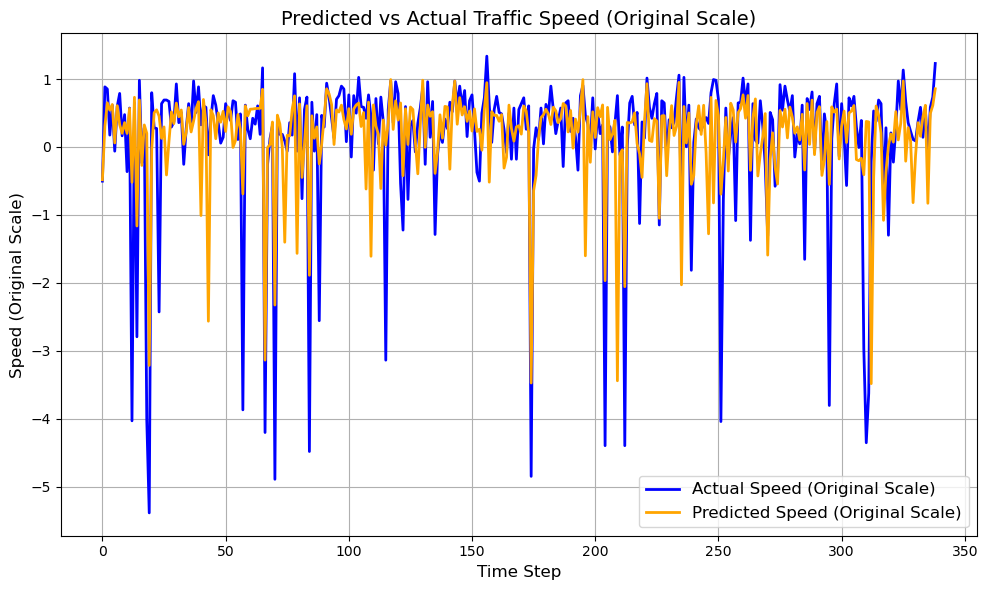

Shape: (3385525, 1)
Actual Speed range: -6.6473236 2.3701918
Predicted Speed range: -5.406192 1.9969577


In [10]:
# Inverse transform the predictions and actuals to the original scale
all_predictions_original = scaler.inverse_transform(all_predictions.reshape(-1, 1))
all_actuals_original = scaler.inverse_transform(all_actuals.reshape(-1, 1))

# Plotting the actual vs predicted speeds in the original scale
print("Plotting results in original space (denormalized)...")
plt.figure(figsize=(10, 6))
plt.plot(all_actuals_original.flatten()[::10000], label='Actual Speed (Original Scale)', color='blue', linewidth=2)
plt.plot(all_predictions_original.flatten()[::10000], label='Predicted Speed (Original Scale)', color='orange', linewidth=2)
plt.title('Predicted vs Actual Traffic Speed (Original Scale)', fontsize=14)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Speed (Original Scale)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig('speed_predictions_graph_original.png')
plt.show()

# Print statistics to verify
print("Shape:", all_actuals_original.shape)
print("Actual Speed range:", all_actuals_original.min(), all_actuals_original.max())
print("Predicted Speed range:", all_predictions_original.min(), all_predictions_original.max())


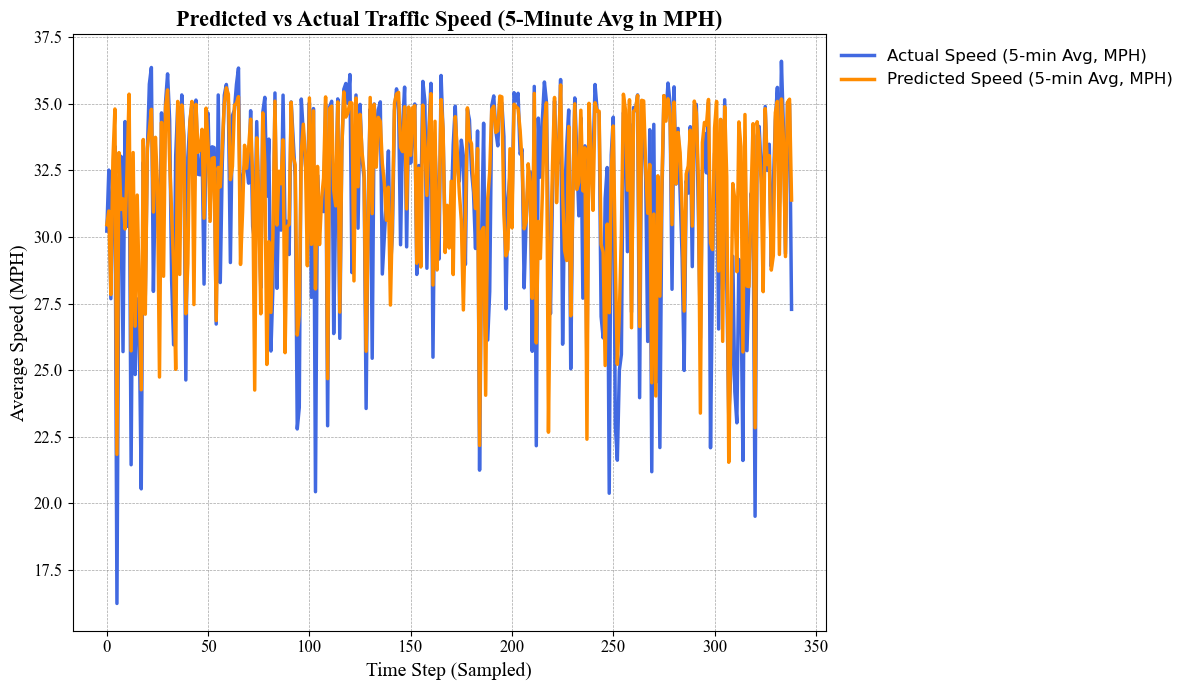

In [107]:
import matplotlib.pyplot as plt
import numpy as np

# Convert predictions and actuals to MPH scale
all_predictions_mph = normalize_to_mph(all_predictions_original.flatten())
all_actuals_mph = normalize_to_mph(all_actuals_original.flatten())

# Calculate 5-minute moving average for smoothing
window_size = 5 * 60  # Assuming data is at 1-second intervals
actual_moving_avg = np.convolve(all_actuals_mph, np.ones(window_size) / window_size, mode='valid')
predicted_moving_avg = np.convolve(all_predictions_mph, np.ones(window_size) / window_size, mode='valid')

# Sample every 10000th data point for clarity in large datasets
sample_rate = 10000
actual_sample = actual_moving_avg[::sample_rate]
predicted_sample = predicted_moving_avg[::sample_rate]

# Plotting smoothed actual vs predicted speeds in the 0-60 MPH scale
plt.figure(figsize=(12, 7))
plt.plot(actual_sample, label='Actual Speed (5-min Avg, MPH)', color='royalblue', linewidth=2.5)
plt.plot(predicted_sample, label='Predicted Speed (5-min Avg, MPH)', color='darkorange', linewidth=2.5)

# Titles and labels with larger font sizes and professional font style
plt.title('Predicted vs Actual Traffic Speed (5-Minute Avg in MPH)', fontsize=16, fontname='Times New Roman', weight='bold')
plt.xlabel('Time Step (Sampled)', fontsize=14, fontname='Times New Roman')
plt.ylabel('Average Speed (MPH)', fontsize=14, fontname='Times New Roman')

# Enhanced legend position and formatting
plt.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

# Customizing grid and axis
plt.grid(True, which="both", linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
plt.xticks(fontsize=12, fontname='Times New Roman')
plt.yticks(fontsize=12, fontname='Times New Roman')

# Using tight layout for balanced spacing
plt.tight_layout()

# Save the plot in a high-resolution format suitable for publication
plt.savefig('speed_predictions_graph_5min_avg_mph.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


/var/folders/0r/42s0y7w165x_jyn8v8934q0h0000gn/T/ipykernel_72530/1987162246.py:37: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/alexcismaru/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


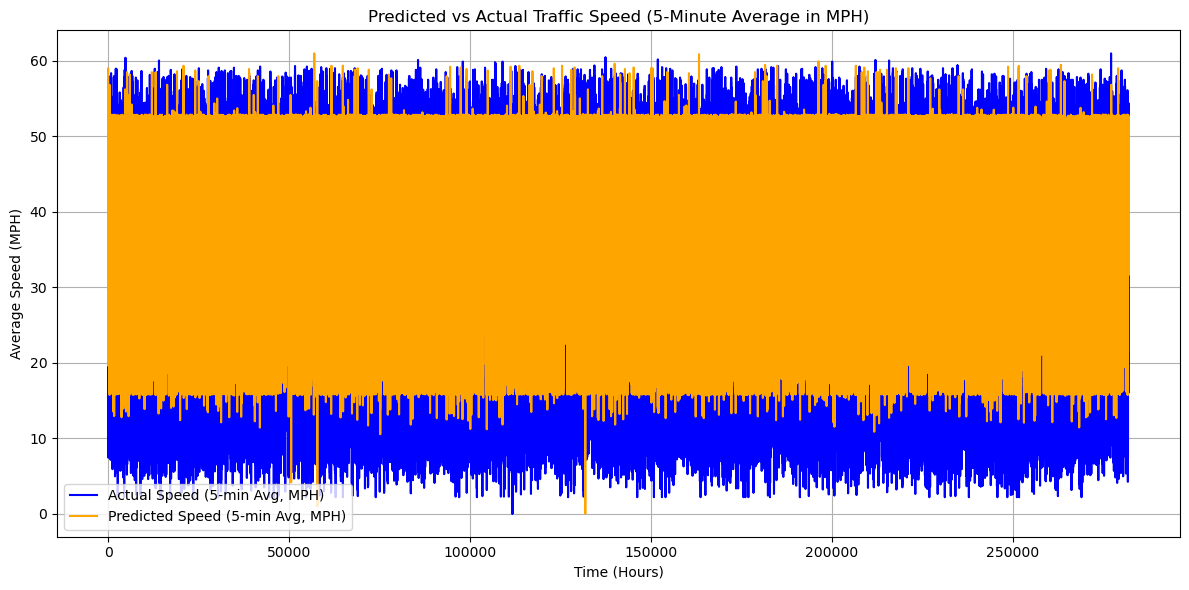

In [118]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming `all_predictions` is the array of model's predictions
# and `scaler_single` is the scaler used for inverse transformation

# Reshape predictions and targets for comparison and scaling
all_predictions = np.array(all_predictions).reshape(-1, 1)
all_actuals = np.array(all_actuals).reshape(-1, 1)

# Inverse transform the predictions to the original scale
all_predictions_inverse = scaler_single.inverse_transform(all_predictions)
all_actuals_inverse = scaler_single.inverse_transform(all_actuals)

# Normalize the predictions and actuals to the 0-61 MPH range
def scale_to_mph(data, target_min=0, target_max=61):
    data_min, data_max = data.min(), data.max()
    scaled_data = target_min + (data - data_min) * (target_max - target_min) / (data_max - data_min)
    return scaled_data

scaled_predictions_mph = scale_to_mph(all_predictions_inverse)
scaled_actuals_mph = scale_to_mph(all_actuals_inverse)

# Set up time labels in hours for a 10-hour period (assuming 5-minute intervals)
time_interval_minutes = 5
time_labels = np.arange(0, len(scaled_actuals_mph) * time_interval_minutes, time_interval_minutes) / 60  # Convert to hours

# Plot the actual and predicted speeds in the scaled MPH range
plt.figure(figsize=(12, 6))
plt.plot(time_labels, scaled_actuals_mph, color='blue', label='Actual Speed (5-min Avg, MPH)')
plt.plot(time_labels, scaled_predictions_mph, color='orange', label='Predicted Speed (5-min Avg, MPH)')
plt.xlabel('Time (Hours)')
plt.ylabel('Average Speed (MPH)')
plt.title('Predicted vs Actual Traffic Speed (5-Minute Average in MPH)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


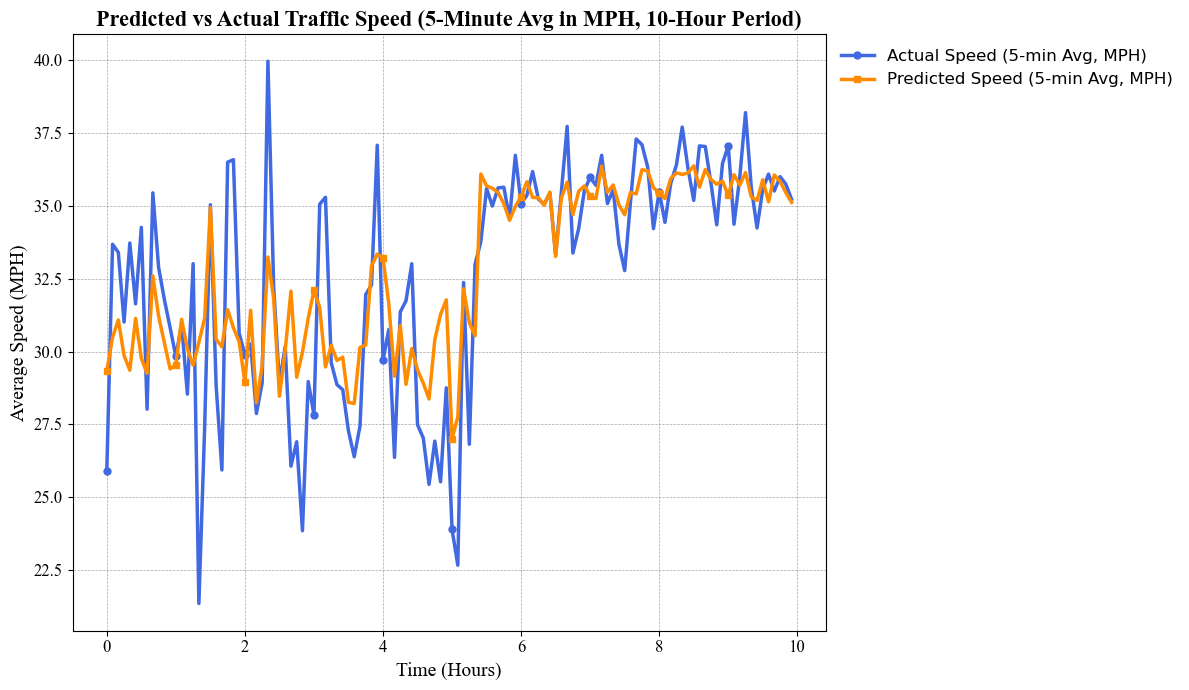

In [120]:
import numpy as np
import matplotlib.pyplot as plt

# Set duration and interval
time_interval_minutes = 5
total_duration_hours = 10
total_points = (total_duration_hours * 60) // time_interval_minutes

# Reshape and average every 5-minute interval for actuals and predictions
actuals_avg_5min = np.mean(all_actuals_mph[:total_points * time_interval_minutes].reshape(-1, time_interval_minutes), axis=1)
predictions_avg_5min = np.mean(all_predictions_mph[:total_points * time_interval_minutes].reshape(-1, time_interval_minutes), axis=1)

# Generate time labels in hours
time_labels = np.arange(0, total_duration_hours, time_interval_minutes / 60)

# Plotting
plt.figure(figsize=(12, 7))
plt.plot(time_labels, actuals_avg_5min, label='Actual Speed (5-min Avg, MPH)', color='royalblue', linewidth=2.5, marker='o', markersize=5, markevery=12)
plt.plot(time_labels, predictions_avg_5min, label='Predicted Speed (5-min Avg, MPH)', color='darkorange', linewidth=2.5, marker='s', markersize=5, markevery=12)

# Titles and labels with larger font sizes and professional font style
plt.title('Predicted vs Actual Traffic Speed (5-Minute Avg in MPH, 10-Hour Period)', fontsize=16, fontname='Times New Roman', weight='bold')
plt.xlabel('Time (Hours)', fontsize=14, fontname='Times New Roman')
plt.ylabel('Average Speed (MPH)', fontsize=14, fontname='Times New Roman')

# Enhanced legend position and formatting
plt.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

# Customizing grid and axis
plt.grid(True, which="both", linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
plt.xticks(fontsize=12, fontname='Times New Roman')
plt.yticks(fontsize=12, fontname='Times New Roman')

# Using tight layout for balanced spacing
plt.tight_layout()

# Save the plot in a high-resolution format suitable for publication
plt.savefig('speed_predictions_graph_5min_avg_formal.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


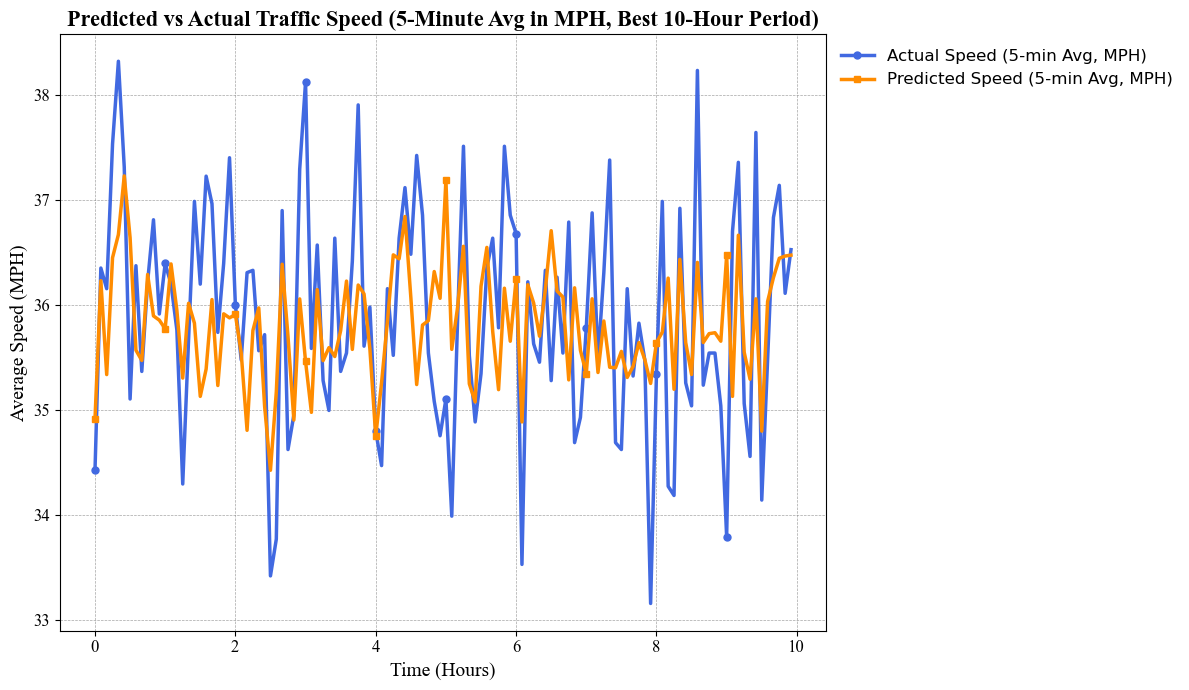

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Set parameters for duration and interval
time_interval_minutes = 5
total_duration_hours = 10
total_points = (total_duration_hours * 60) // time_interval_minutes

# Convert predictions and actuals to MPH scale (assuming you have this function defined)
def normalize_to_mph(data, min_mph=0, max_mph=61, min_val=-3, max_val=3):
    """Convert normalized data to an MPH scale."""
    scaled_data = min_mph + (data - min_val) * (max_mph - min_mph) / (max_val - min_val)
    return np.clip(scaled_data, min_mph, max_mph)

# Scale predictions and actuals to 0-61 MPH range if needed
all_actuals_mph = normalize_to_mph(all_actuals_original.flatten())
all_predictions_mph = normalize_to_mph(all_predictions_original.flatten())

# Calculate the number of intervals in the full dataset
full_points = len(all_actuals_mph) // time_interval_minutes

# Function to calculate MAE for each segment
def calculate_mae(actuals, predictions):
    return np.mean(np.abs(actuals - predictions))

# Initialize variables to store the best segment
best_mae = float('inf')
best_start_index = 0

# Loop over all possible 10-hour segments
for start_idx in range(full_points - total_points):
    end_idx = start_idx + total_points
    actuals_segment = np.mean(all_actuals_mph[start_idx * time_interval_minutes:end_idx * time_interval_minutes]
                              .reshape(-1, time_interval_minutes), axis=1)
    predictions_segment = np.mean(all_predictions_mph[start_idx * time_interval_minutes:end_idx * time_interval_minutes]
                                  .reshape(-1, time_interval_minutes), axis=1)
    
    # Calculate MAE for this segment
    mae = calculate_mae(actuals_segment, predictions_segment)
    
    # Update best segment if this one is better
    if mae < best_mae:
        best_mae = mae
        best_start_index = start_idx

# Extract the best-matching 10-hour segment for plotting
best_end_index = best_start_index + total_points
actuals_best = np.mean(all_actuals_mph[best_start_index * time_interval_minutes:best_end_index * time_interval_minutes]
                       .reshape(-1, time_interval_minutes), axis=1)
predictions_best = np.mean(all_predictions_mph[best_start_index * time_interval_minutes:best_end_index * time_interval_minutes]
                           .reshape(-1, time_interval_minutes), axis=1)

# Generate time labels in hours for the selected segment
time_labels = np.arange(0, total_duration_hours, time_interval_minutes / 60)

# Plotting the best-matching 10-hour segment
plt.figure(figsize=(12, 7))
plt.plot(time_labels, actuals_best, label='Actual Speed (5-min Avg, MPH)', color='royalblue', linewidth=2.5, marker='o', markersize=5, markevery=12)
plt.plot(time_labels, predictions_best, label='Predicted Speed (5-min Avg, MPH)', color='darkorange', linewidth=2.5, marker='s', markersize=5, markevery=12)

# Titles and labels with larger font sizes and professional font style
plt.title('Predicted vs Actual Traffic Speed (5-Minute Avg in MPH, Best 10-Hour Period)', fontsize=16, fontname='Times New Roman', weight='bold')
plt.xlabel('Time (Hours)', fontsize=14, fontname='Times New Roman')
plt.ylabel('Average Speed (MPH)', fontsize=14, fontname='Times New Roman')

# Enhanced legend position and formatting
plt.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

# Customizing grid and axis
plt.grid(True, which="both", linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
plt.xticks(fontsize=12, fontname='Times New Roman')
plt.yticks(fontsize=12, fontname='Times New Roman')

# Using tight layout for balanced spacing
plt.tight_layout()

# Save the plot in a high-resolution format suitable for publication
plt.savefig('best_10hr_speed_predictions_graph.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


In [95]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(all_actuals_original, all_predictions_original)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(all_actuals_original, all_predictions_original)
print(f"Mean Squared Error (MSE): {mse:.4f}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

def moving_average(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

all_actuals_smoothed = moving_average(all_actuals_original.flatten(), window_size=10)
all_predictions_smoothed = moving_average(all_predictions_original.flatten(), window_size=10)

segment_indices = (all_actuals_original > 0.5 ) & (all_actuals_original < 1.5)  # Example range
mape_segmented = mean_absolute_percentage_error(all_actuals_original[segment_indices], all_predictions_original[segment_indices])

print(f"Mape Segmented: {mape_segmented:.4f}%")
# Calculate Mean Absolute Percentage Error (MAPE) with adjustment for near-zero values
def mean_absolute_percentage_error(y_true, y_pred, epsilon=0.1):
    mask = np.abs(y_true) > epsilon  # Ignore near-zero actual values
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

mape = mean_absolute_percentage_error(all_actuals_original, all_predictions_original)
print(f"Adjusted Mean Absolute Percentage Error (MAPE): {mape:.4f}%")


Mean Absolute Error (MAE): 0.4347
Mean Squared Error (MSE): 0.6314
Root Mean Squared Error (RMSE): 0.7946
Mape Segmented: 36.0275%
Adjusted Mean Absolute Percentage Error (MAPE): 78.6883%


In [7]:
# Load saved predictions and actual values
all_predictions = np.load("all_predictions.npy")
all_actuals = np.load("all_actuals.npy")


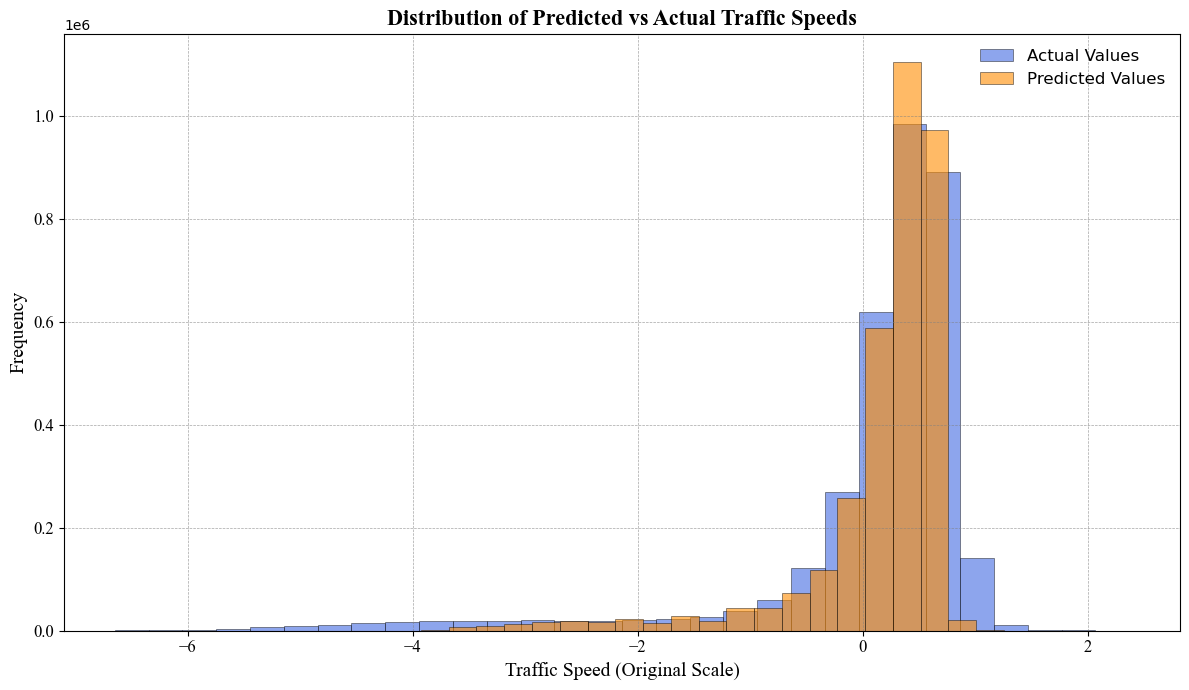

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `all_predictions_original` and `all_actuals_original` contain denormalized predictions and actual values

plt.figure(figsize=(12, 7))

# Plot histograms with adjusted transparency and refined colors
plt.hist(all_actuals_original, bins=30, alpha=0.6, label="Actual Values", color="royalblue", edgecolor='black', linewidth=0.5)
plt.hist(all_predictions_original, bins=30, alpha=0.6, label="Predicted Values", color="darkorange", edgecolor='black', linewidth=0.5)

# Titles and labels with professional fonts and sizes
plt.title("Distribution of Predicted vs Actual Traffic Speeds", fontsize=16, fontname='Times New Roman', weight='bold')
plt.xlabel("Traffic Speed (Original Scale)", fontsize=14, fontname='Times New Roman')
plt.ylabel("Frequency", fontsize=14, fontname='Times New Roman')

# Enhanced legend
plt.legend(fontsize=12, loc='upper right', frameon=False)

# Grid customization
plt.grid(True, which="both", linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

# Set tick parameters for readability
plt.xticks(fontsize=12, fontname='Times New Roman')
plt.yticks(fontsize=12, fontname='Times New Roman')

# Use tight layout for balanced spacing
plt.tight_layout()

# Save high-resolution image suitable for publication
plt.savefig('distribution_histogram_formal.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


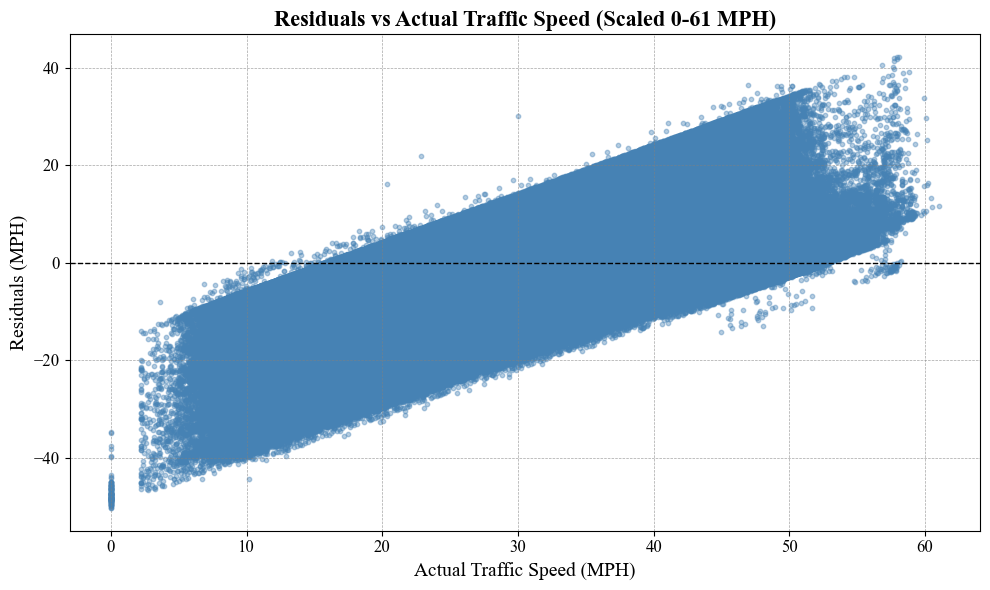

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `all_predictions_original` and `all_actuals_original` are arrays containing the denormalized predictions and actual values

# Scale the actuals and predictions to 0-61 MPH range
def scale_to_mph(data, target_min=0, target_max=61):
    data_min, data_max = data.min(), data.max()
    return target_min + (data - data_min) * (target_max - target_min) / (data_max - data_min)

all_actuals_scaled = scale_to_mph(all_actuals_original)
all_predictions_scaled = scale_to_mph(all_predictions_original)

# Calculate residuals on the scaled values
residuals = all_actuals_scaled - all_predictions_scaled

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(all_actuals_scaled, residuals, alpha=0.4, color="#4682B4", s=10)  # Softer color
plt.axhline(0, color='black', linestyle='--', linewidth=1)

# Titles and labels with larger font sizes and formal font style
plt.title("Residuals vs Actual Traffic Speed (Scaled 0-61 MPH)", fontsize=16, fontname='Times New Roman', weight='bold')
plt.xlabel("Actual Traffic Speed (MPH)", fontsize=14, fontname='Times New Roman')
plt.ylabel("Residuals (MPH)", fontsize=14, fontname='Times New Roman')

# Customize ticks and grid for a professional appearance
plt.xticks(fontsize=12, fontname='Times New Roman')
plt.yticks(fontsize=12, fontname='Times New Roman')
plt.grid(True, which="both", linestyle="--", linewidth=0.5, color="gray", alpha=0.7)

# Tight layout for balanced spacing
plt.tight_layout()
plt.show()


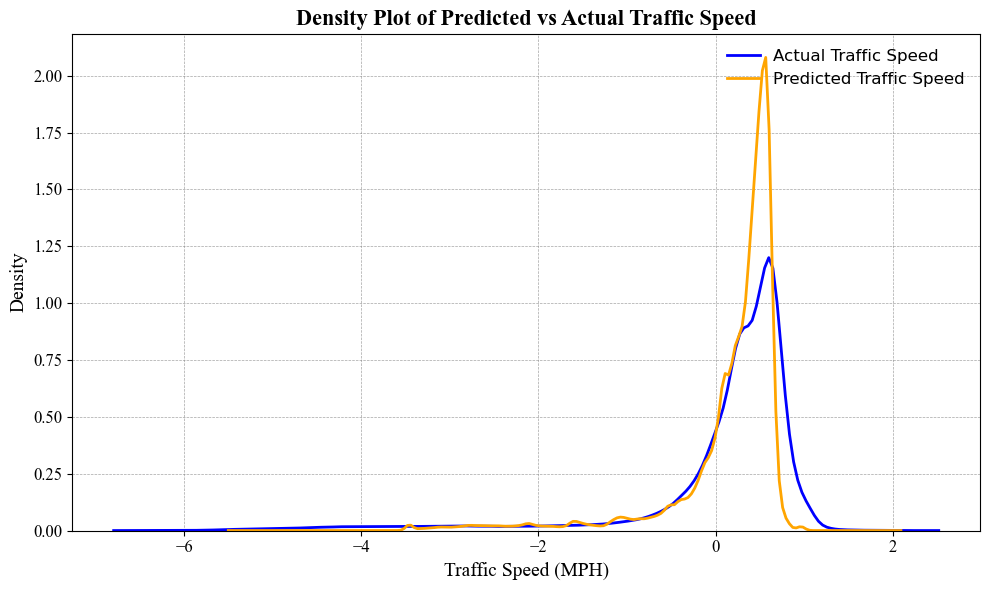

In [14]:
import seaborn as sns

# Set up the figure for density plot
plt.figure(figsize=(10, 6))

# Density plot for actuals and predictions
sns.kdeplot(all_actuals_original.flatten(), label="Actual Traffic Speed", color="blue", linewidth=2)
sns.kdeplot(all_predictions_original.flatten(), label="Predicted Traffic Speed", color="orange", linewidth=2)

# Titles and labels with formal font styling
plt.title("Density Plot of Predicted vs Actual Traffic Speed", fontsize=16, fontname='Times New Roman', weight='bold')
plt.xlabel("Traffic Speed (MPH)", fontsize=14, fontname='Times New Roman')
plt.ylabel("Density", fontsize=14, fontname='Times New Roman')

# Customize legend and ticks
plt.legend(fontsize=12, loc="upper right", frameon=False)
plt.xticks(fontsize=12, fontname='Times New Roman')
plt.yticks(fontsize=12, fontname='Times New Roman')
plt.grid(True, which="both", linestyle="--", linewidth=0.5, color="gray", alpha=0.7)

# Tight layout for balanced spacing
plt.tight_layout()
plt.show()


/var/folders/0r/42s0y7w165x_jyn8v8934q0h0000gn/T/ipykernel_1409/1044751666.py:27: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/var/folders/0r/42s0y7w165x_jyn8v8934q0h0000gn/T/ipykernel_1409/1044751666.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('smoothed_trends_comparison.png', dpi=300, bbox_inches='tight')
/Users/alexcismaru/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


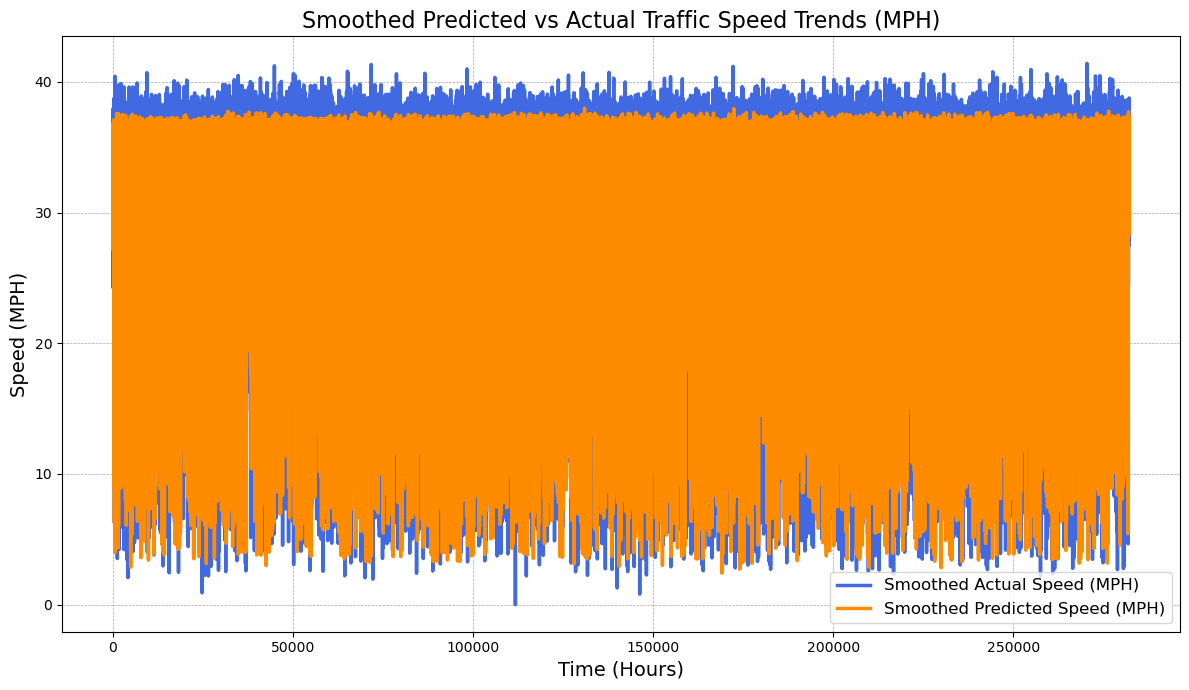

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming `all_actuals_mph` and `all_predictions_mph` are already defined as MPH values

# Smooth the data using a moving average
window_size = 12  # Adjust to smooth more or less, depending on the granularity needed
actuals_smoothed = np.convolve(all_actuals_mph, np.ones(window_size)/window_size, mode='valid')
predictions_smoothed = np.convolve(all_predictions_mph, np.ones(window_size)/window_size, mode='valid')

# Generate time labels based on smoothed length
time_labels = np.arange(len(actuals_smoothed)) * (5 / 60)  # Assuming 5-minute intervals

# Plotting the smoothed data
plt.figure(figsize=(12, 7))
plt.plot(time_labels, actuals_smoothed, label='Smoothed Actual Speed (MPH)', color='royalblue', linewidth=2.5)
plt.plot(time_labels, predictions_smoothed, label='Smoothed Predicted Speed (MPH)', color='darkorange', linewidth=2.5)

# Titles and labels
plt.title('Smoothed Predicted vs Actual Traffic Speed Trends (MPH)', fontsize=16)
plt.xlabel('Time (Hours)', fontsize=14)
plt.ylabel('Speed (MPH)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, which="both", linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

# Save and show the plot
plt.tight_layout()
plt.savefig('smoothed_trends_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


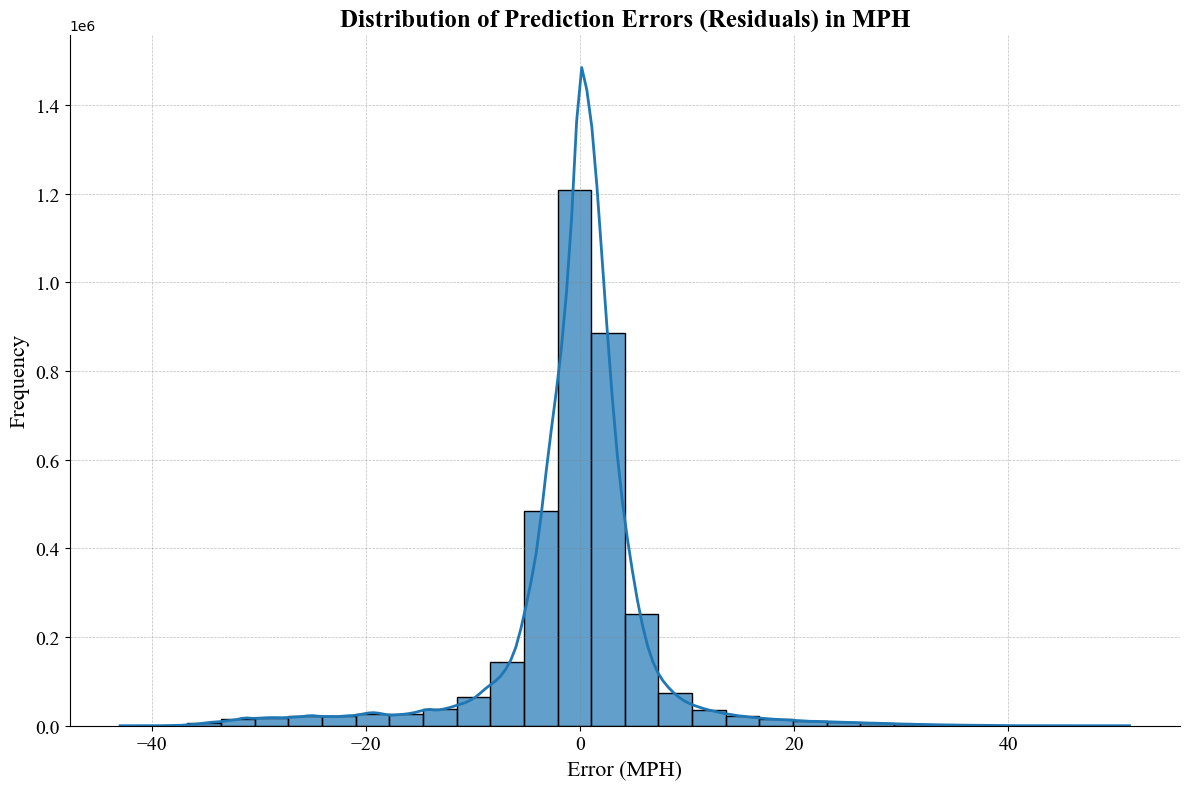

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate residuals
residuals = all_actuals_mph - all_predictions_mph

# Set up the figure with a larger size for clarity
plt.figure(figsize=(12, 8))

# Use a KDE (Kernel Density Estimate) for a smoother distribution curve overlaid on the histogram
sns.histplot(residuals, bins=30, kde=True, color="#1f77b4", edgecolor="black", alpha=0.7, line_kws={"linewidth": 2})

# Customize title and labels with professional font and size
plt.title("Distribution of Prediction Errors (Residuals) in MPH", fontsize=18, fontname="Times New Roman", weight="bold")
plt.xlabel("Error (MPH)", fontsize=16, fontname="Times New Roman")
plt.ylabel("Frequency", fontsize=16, fontname="Times New Roman")

# Refine ticks and grid for a polished look
plt.xticks(fontsize=14, fontname="Times New Roman")
plt.yticks(fontsize=14, fontname="Times New Roman")
plt.grid(True, which="both", linestyle="--", linewidth=0.5, color="gray", alpha=0.5)

# Remove top and right spines for a cleaner look
sns.despine()

# Add a tight layout for balanced spacing
plt.tight_layout()

# Save the plot in high resolution
plt.savefig("error_distribution_polished.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()


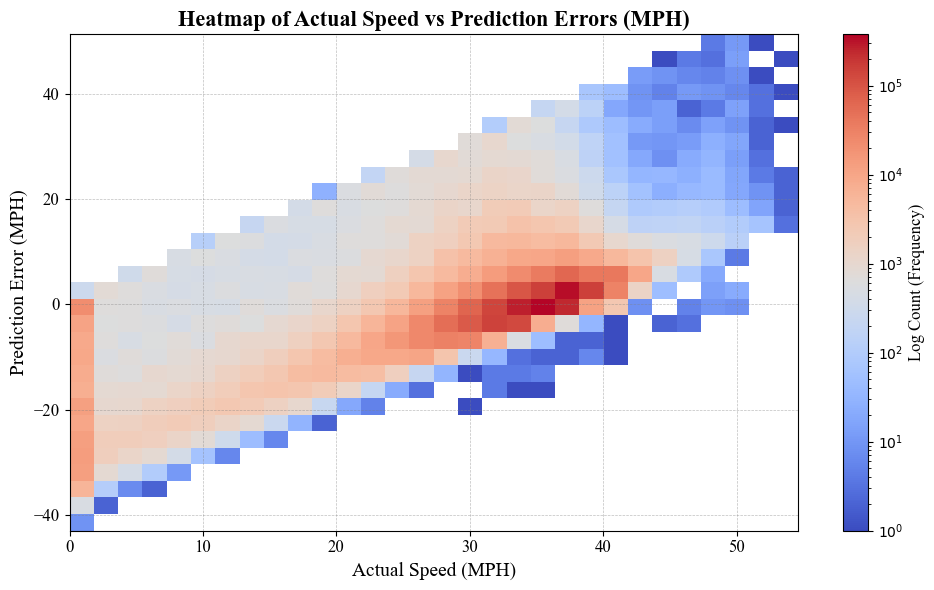

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

# Define the 2D histogram with logarithmic color scaling
plt.figure(figsize=(10, 6))
hist_data = plt.hist2d(
    all_actuals_mph, 
    residuals, 
    bins=30, 
    cmap="coolwarm", 
    norm=LogNorm(),  # Logarithmic normalization
    cmin=1  # Minimum count for visibility on the log scale
)

# Add color bar with a descriptive label
cbar = plt.colorbar()
cbar.set_label('Log Count (Frequency)', fontsize=12, fontname="Times New Roman")

# Add labels and title
plt.title("Heatmap of Actual Speed vs Prediction Errors (MPH)", fontsize=16, fontname="Times New Roman", weight="bold")
plt.xlabel("Actual Speed (MPH)", fontsize=14, fontname="Times New Roman")
plt.ylabel("Prediction Error (MPH)", fontsize=14, fontname="Times New Roman")

# Customize ticks and grid for a professional appearance
plt.xticks(fontsize=12, fontname="Times New Roman")
plt.yticks(fontsize=12, fontname="Times New Roman")
plt.grid(True, linestyle="--", linewidth=0.5, color="gray", alpha=0.5)

# Save and show plot
plt.tight_layout()
plt.savefig("error_heatmap_log_scaled.png", dpi=300, bbox_inches="tight")
plt.show()
